C:\Users\whdal\AppData\Local\Temp\ipykernel_30104\2735725160.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IdMax'] = pd.to_numeric(df['IdMax'], errors='coerce')
C:\Users\whdal\AppData\Local\Temp\ipykernel_30104\2735725160.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['block'] = df['IdMax'].notna().cumsum()


                    Vgate Vdrain                    Idrain     IdMax time_s
422                    -3    0.1   -3.0000000000000002E-15  0.000001   2000
423                 -2.95    0.1    1.2000000000000001E-14       NaN   2000
424                  -2.9    0.1                 -1.89E-13       NaN   2000
425                 -2.85    0.1                 -1.63E-13       NaN   2000
426   -2.8000000000000003    0.1   -2.5200000000000004E-13       NaN   2000
427                 -2.75    0.1   -9.5000000000000012E-14       NaN   2000
428                  -2.7    0.1    -5.700000000000001E-14       NaN   2000
429                 -2.65    0.1                 -1.48E-13       NaN   2000
430                  -2.6    0.1   -1.4500000000000001E-13       NaN   2000
431   -2.5500000000000003    0.1                 -1.53E-13       NaN   2000
432                  -2.5    0.1   -1.3700000000000002E-13       NaN   2000
433                 -2.45    0.1   -1.4900000000000002E-13       NaN   2000
434         

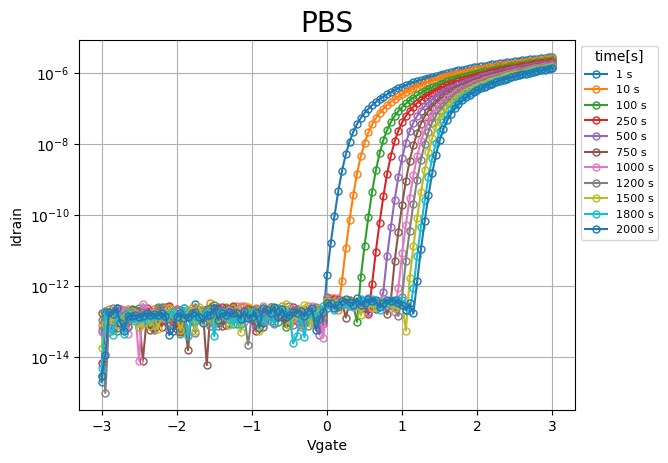

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv


path = "PBTI_IGZO_new [251203_ALD IGZO_#1_R1C0_40_20_1(1) _ 12_8_2025 12_26_42 PM].csv"
# csv 빈칸 열이 난잡할때 그대로 들고오는 코드
rows = []
with open(path, "r", encoding="utf-8-sig", errors="replace", newline="") as f:
    reader = csv.reader(f)
    for r in reader:
        rows.append(r)

max_len = max(len(r) for r in rows)
rows = [r + [""] * (max_len - len(r)) for r in rows]  # 부족한 열은 빈칸으로 채움

raw_data = pd.DataFrame(rows)  # 모든 셀이 보존됨

# 원하는 데이터만 들고오기
raw_data2 = raw_data[0].isin(['DataValue'])

raw_data = raw_data[raw_data2]
raw_data = raw_data.iloc[:,1:6]
raw_data.columns = ['Vgate','Vdrain','Idrain','IdMax','Vth@Id']


df = raw_data

time = df.loc[df['Idrain'].isin([' ']),'Vgate']
time_list = time.tolist()
time_list = list(reversed(time_list))
time_count = len(time_list)
df = df.iloc[time_count:,:]

df['IdMax'] = pd.to_numeric(df['IdMax'], errors='coerce')

# 1) IdMax가 존재하는 행마다 블록 번호 1,2,3,... 증가
df['block'] = df['IdMax'].notna().cumsum()

# (선택) 만약 IdMax 나오기 전 구간이 있으면 block=0인데, 보통 필요 없으니 제거
df = df[df['block'] > 0].copy()

# 2) block 번호를 time_list에 매핑
#    block=1 -> time_list[0], block=2 -> time_list[1], ...
mapping = {i + 1: t for i, t in enumerate(time_list)}

df['time_s'] = df['block'].map(mapping)



# 5) 정리: 필요 없는 block 컬럼 제거하고 확인
print(df[['Vgate','Vdrain','Idrain','IdMax','time_s']].head(30))


df['Vgate']  = pd.to_numeric(df['Vgate'], errors='coerce')
df['Idrain'] = pd.to_numeric(df['Idrain'], errors='coerce').abs()
df['time_s'] = pd.to_numeric(df['time_s'], errors='coerce')

# 2) 유효값만 남기기
plot_df = df.dropna(subset=['Vgate', 'Idrain', 'time_s']).copy()

# (선택) time 순서 정렬
times = sorted(plot_df['time_s'].unique())

plt.figure()

for t in times:
    d = plot_df[plot_df['time_s'] == t].sort_values('Vgate')
    plt.semilogy(d['Vgate'].to_numpy(), d['Idrain'].to_numpy(),marker = 'o',markerfacecolor = 'none', markersize = 5,linestyle='-', label=f'{int(t)} s')



plt.xlabel('Vgate')
plt.ylabel('Idrain')
plt.title('PBS', fontsize = 20)
plt.legend(title = 'time[s]',bbox_to_anchor=(1, 1), loc='upper left', fontsize = 8)   
plt.grid(True)
plt.show()

In [2]:
target1 = -10                               # log(ID) = -10이 타겟임(vth 산출용)
target2 = -9                                # SS 산출용
vth_by_time_10 = {}  # time별 Vth 저장
vth_by_time_9 = {}  # time별 Vth 저장
for vd, g in df.groupby('time_s'):              # 앞에 있는 vd는 df.groupby('VD')의 key인 'VD'를 받는것이고 뒤에 있는 g는 key 'VD'에 해당하는 값을 받는다.
    g = g.sort_values('Idrain')

    VG = g['Vgate'].to_numpy()                 # VG column을 숫자로 변환
    ID = g['Idrain'].to_numpy()                 # ID column을 숫자로 변환

    # log10(|ID|) 계산: 0은 로그 불가 → 아주 작은 값으로 클리핑
    absID = np.abs(ID)
    absID = np.clip(absID, 1e-300, None)   # underflow 방지
    logI = np.log10(absID)

     # ===== 3) target 교차 구간 탐색 + 선형 보간 =====
    diff1 = logI - target1
    diff2 = logI - target2
    cross_idx_10 = np.where(diff1[:-1] * diff1[1:] <= 0)[0]  # target을 사이에 두는 인접 점(★★★★★★★★★★★★ np.where(condition,True,False))
    cross_idx_9 = np.where(diff2[:-1] * diff2[1:] <= 0)[0] 

    if len(cross_idx_10) == 0:
        vth_by_time_10[vd] = np.nan
        continue
    if len(cross_idx_9) == 0:
        vth_by_time_9[vd] = np.nan
        continue
    # 첫 번째 crossing 사용 (원하면 마지막 crossing: cross_idx[-1])
    i1 = cross_idx_10[0]
    i2 = cross_idx_9[0]

    x0, x1 = VG[i1], VG[i1+1]
    y0, y1 = logI[i1], logI[i1+1]

    z0, z1 = VG[i2], VG[i2+1]
    t0, t1 = logI[i2], logI[i2+1]    

    # 분모 0 방지
    if y1 == y0:
        vth_10 = np.nan
    else:
        vth_10 = x0 + (target1 - y0) * (x1 - x0) / (y1 - y0)

    vth_by_time_10[vd] = vth_10
    
    # 분모 0 방지
    if t1 == t0:
        vth_9 = np.nan
    else:
        vth_9 = z0 + (target2 - t0) * (z1 - z0) / (t1 - t0)

    vth_by_time_9[vd] = vth_9
    
# ===== 5) VD별 Vth 출력 =====
print(f"Vth @ log10(|ID|) = {target1} (by times)")
for vd in sorted(vth_by_time_10.keys()):
    print(f"times={vd}[s]: Vth={vth_by_time_10[vd]:.2f}")

    # ===== 6) VD별 SS 계산 =====
ss_by_vd = {}  # VD별 SS 저장 (mV/dec)

for vd in vth_by_time_10.keys():
    vg_at_10 = vth_by_time_10.get(vd, np.nan)  # log|ID|=-10에서 VG
    vg_at_9  = vth_by_time_9.get(vd, np.nan)   # log|ID|=-9에서 VG

    # 둘 중 하나라도 NaN이면 SS도 NaN
    if np.isnan(vg_at_10) or np.isnan(vg_at_9):
        ss_by_vd[vd] = np.nan
    else:
        ss_v_per_dec = (vg_at_9 - vg_at_10) / (target2 - target1)  # 여기서는 /1이라 동일하지만 일반식으로 작성
        ss_by_vd[vd] = ss_v_per_dec * 1000  # mV/dec

# ===== 7) VD별 SS 출력 =====
print(f"SS (mV/dec) using log10(|ID|)={target1} to {target2} (by times)")
for vd in sorted(ss_by_vd.keys()):
    print(f"times={vd}[s]: Vth={vth_by_time_10[vd]:.2f}, SS={ss_by_vd[vd]:.2f}")

Vth @ log10(|ID|) = -10 (by times)
times=1[s]: Vth=0.10
times=10[s]: Vth=0.31
times=100[s]: Vth=0.55
times=250[s]: Vth=0.71
times=500[s]: Vth=0.87
times=750[s]: Vth=0.98
times=1000[s]: Vth=1.07
times=1200[s]: Vth=1.13
times=1500[s]: Vth=1.20
times=1800[s]: Vth=1.27
times=2000[s]: Vth=1.31
SS (mV/dec) using log10(|ID|)=-10 to -9 (by times)
times=1[s]: Vth=0.10, SS=76.88
times=10[s]: Vth=0.31, SS=75.58
times=100[s]: Vth=0.55, SS=74.12
times=250[s]: Vth=0.71, SS=72.82
times=500[s]: Vth=0.87, SS=71.89
times=750[s]: Vth=0.98, SS=71.83
times=1000[s]: Vth=1.07, SS=72.21
times=1200[s]: Vth=1.13, SS=71.35
times=1500[s]: Vth=1.20, SS=73.14
times=1800[s]: Vth=1.27, SS=72.77
times=2000[s]: Vth=1.31, SS=73.77


In [3]:
print(df)

      Vgate Vdrain        Idrain     IdMax Vth@Id  block  time_s
425   -3.00    0.1  2.900000e-14  0.000002      3      1       1
426   -2.95    0.1  1.260000e-13       NaN      3      1       1
427   -2.90    0.1  1.970000e-13       NaN      3      1       1
428   -2.85    0.1  2.550000e-13       NaN      3      1       1
429   -2.80    0.1  1.500000e-13       NaN      3      1       1
...     ...    ...           ...       ...    ...    ...     ...
5494   2.80    0.1  3.214380e-06       NaN      3     14    3000
5495   2.85    0.1  3.288840e-06       NaN      3     14    3000
5496   2.90    0.1  3.363590e-06       NaN      3     14    3000
5497   2.95    0.1  3.438410e-06       NaN      3     14    3000
5498   3.00    0.1  3.513420e-06       NaN      3     14    3000

[1694 rows x 7 columns]
